In [2]:
%cd ../

/home/hughes/usr/d_vae_hea


In [3]:
import argparse
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from torch.optim import Adam
from pyro.optim import ReduceLROnPlateau
from pyro.contrib.examples.util import print_and_log
import pyro.poutine as poutine

In [4]:
from utils.custom_mlp import MLP, Exp
from utils.featurization import top30, calculate_compositions, calculate_engineered_features

In [5]:
import matplotlib
matplotlib.rc('font', **{'size': 18})
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

In [6]:
import numpy as np
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.special import expit
import pdb
import plotly.graph_objects as go
import plotly.express as px
import pickle
from datetime import datetime

**Import composition and engineered data and merge them into a single dataframe**

In [7]:
data_directory = './data/'

hea_top30_data = pd.read_csv(data_directory + 'HEA_top30_comps.csv', comment='#')
hea_feature_engineered_df = pd.read_csv(data_directory + 'HEA_feature_engineered.csv')

hea_top30_data = hea_top30_data.drop_duplicates(subset='Alloys', keep='first')
hea_feature_engineered_df = hea_feature_engineered_df.drop_duplicates(subset='Alloys', keep='first')

merged_df = pd.merge(hea_top30_data, hea_feature_engineered_df.drop(columns='Class'), on='Alloys', how='inner')
merged_df.head()

,Alloys,Class,Fe,Ni,Cr,Co,Al,Ti,Cu,Mo,...,Li,Sc,k,vm,tm,vac,delta,delta_chi,delta_s_mix,delta_h_mix
0,Mg1Ni1,0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,112.0,10.300,1325.65,6.0,5.263158,0.300,5.762824,-8.0
1,Mg1Cu1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,...,0.0,0.0,92.5,10.550,1140.46,6.5,5.263158,0.295,5.762824,-6.7
2,Fe1Mg1,0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,107.0,10.550,1367.15,5.0,3.448276,0.260,5.762824,23.2
3,Cr1Mg1,0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,102.5,10.615,1551.65,4.0,3.448276,0.175,5.762824,31.7
4,Mg1V1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,102.0,11.175,1553.15,3.5,5.263158,0.160,5.762824,30.2


**Construct Dataset classes to load data**

In [8]:
### this class is for importing composition data, engineered data, and labels ###
class HEAFeatureDataset(Dataset): 
    def __init__(self, pd, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        labels = np.array(self.data.iloc[idx]["Class"], np.float32)
        data = np.array(self.data.iloc[idx]["Fe":"Sc"], np.float32)
        data_engineered = np.array(self.data.iloc[idx]["k":"delta_h_mix"], np.float32)
        if self.transform:
            data = self.transform(data)

        return torch.tensor(data * 100), torch.tensor(data_engineered), torch.tensor(labels).unsqueeze(-1)

### this class is for importing just composition data and engineered data, no labels###
class HEAFeatureDatasetUnlabelled(Dataset):
    def __init__(self, pd, transform=None):
        """
        Args:
            pd (DataFrame): pandas dataframe
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = np.array(self.data.iloc[idx]["Fe":"Sc"], np.float32)
        data_engineered = np.array(self.data.iloc[idx]["k":"delta_h_mix"], np.float32)
        if self.transform:
            data = self.transform(data)

        return torch.tensor(data * 100), torch.tensor(data_engineered)

**load train, test, val dataframes as used during training**

In [9]:
labelled_hea = pickle.load(open('./data/labelled_hea.pk', 'rb'))
unlabelled_hea = pickle.load(open('./data/unlabelled_hea.pk', 'rb'))
test_hea = pickle.load(open('./data/test_hea.pk', 'rb'))
validation_hea = pickle.load(open('./data/validation_hea.pk', 'rb'))

In [10]:
FEATURE_SIZE = 30
BATCH_SIZE = 32
DEFAULT_HIDDEN_DIMS = [100,100]
DEFAULT_Z_DIM = 2

In [11]:
print("Reading in dataset...")

hea_feature_dataset = HEAFeatureDataset(pd=labelled_hea)
hea_feature_loader = torch.utils.data.DataLoader(hea_feature_dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True,)

N_samples = len(hea_feature_dataset)
print("Number of labelled observations:", N_samples)

hea_feature_dataset_ul = HEAFeatureDataset(pd=unlabelled_hea)
hea_feature_loader_ul = torch.utils.data.DataLoader(hea_feature_dataset_ul,
                                                  batch_size=BATCH_SIZE, shuffle=True,)
N_samples = len(hea_feature_dataset_ul)
print("Number of unlabelled observations:", N_samples)

hea_feature_dataset_val = HEAFeatureDataset(pd=validation_hea)
hea_feature_loader_val = torch.utils.data.DataLoader(hea_feature_dataset_val,
                                                  batch_size=len(hea_feature_dataset_val), shuffle=True,)
N_samples = len(hea_feature_dataset_val)
print("Number of validation observations:", N_samples)

hea_feature_dataset_test = HEAFeatureDataset(pd=test_hea)
hea_feature_loader_test = torch.utils.data.DataLoader(hea_feature_dataset_test,
                                                  batch_size=BATCH_SIZE, shuffle=True,)
N_samples = len(hea_feature_dataset_test)
print("Number of test observations:", N_samples)

data_loaders = {"sup": hea_feature_loader , "unsup": hea_feature_loader_ul, "val": hea_feature_loader_val, "test": hea_feature_loader_test}
### "sup" is for supervised training data, "unsup" is for unsupervised training data, "val" is for validation, "test" is for test

Reading in dataset...
Number of labelled observations: 864
Number of unlabelled observations: 296
Number of validation observations: 75
Number of test observations: 138


**Define Model, this is the same as training**

In [12]:
class SSVAE(nn.Module):
    """
    The semi-supervised VAE

    :param output_size: size of the tensor representing the class label (1 for our data, as it's binary)
    :param input_size: size of the tensor representing the input (30 for our data)
    :param z_dim: size of the tensor representing the latent random variable z
    :param hidden_layers: a tuple (or list) of MLP layers to be used in the neural networks
                          representing the parameters of the distributions in our model
    :param use_cuda: use GPUs for faster training
    :param aux_loss_multiplier: the multiplier to use with the auxiliary loss
    """

    def __init__(
        self,
        output_size=1,
        input_size=30,
        z_dim=2,
        hidden_layers=(500,),
        config_enum=None,
        use_cuda=False,
        aux_loss_multiplier=None,
    ):
        super().__init__()

        # initialize the class with all arguments provided to the constructor
        self.output_size = output_size
        self.input_size = input_size
        self.z_dim = z_dim
        self.hidden_layers = hidden_layers
        self.allow_broadcast = config_enum == "parallel"
        self.use_cuda = use_cuda
        self.aux_loss_multiplier = aux_loss_multiplier

        # define and instantiate the neural networks representing
        # the parameters of various distributions in the model
        self.setup_networks()

    def setup_networks(self):
        z_dim = self.z_dim
        hidden_sizes = self.hidden_layers

        # Encoder for y outputs a single probability per instance (Bernoulli parameter)
        self.encoder_y = MLP(
            [8] + hidden_sizes + [1],  # Output size is 1 for Bernoulli probability
            activation=nn.Softplus,
            output_activation=nn.Sigmoid,  # Sigmoid activation for a valid probability
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        # Encoder for z outputs parameters for a normal distribution
        # Final output size is [z_dim, z_dim] for mean and std dev, activations are None and Exp (for std)
        self.encoder_z = MLP(
            [self.input_size + 1] + hidden_sizes + [[z_dim, z_dim]],  # Added +1 for binary y
            activation=nn.Softplus,
            output_activation=[None, Exp],  # Exp to ensure positive standard deviation
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        # Decoder outputs probabilities for a multinomial distribution
        # Assuming the total number of categories in x is defined by input_size
        self.decoder = MLP(
            [z_dim + 1] + hidden_sizes + [self.input_size],  # Adjust input for binary y
            activation=nn.Softplus,
            output_activation=nn.Softmax(dim=-1),  # Softmax to create a probability distribution
            allow_broadcast=self.allow_broadcast,
            use_cuda=self.use_cuda,
        )

        if self.use_cuda:
            self.cuda()

    def model(self, xs, es=None, ys=None):
        """
        The model corresponds to the following generative process:
        p(z) = normal(0,I)              # prior on latents
        p(y|x) = Bernoulli(1/2.)     # which phase (semi-supervised)
        p(x|y,z) = Multinomial(loc(y,z))   # output composition
        loc is given by a neural network  `decoder`

        :param xs: a batch of composition data
        :param ys: (optional) a batch of the class labels i.e.
                   phase corresponding to a given composition
        :return: None
        """
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("ss_vae", self)

        batch_size = xs.size(0)
        options = dict(dtype=xs.dtype, device=xs.device)
        with pyro.plate("data"):
            # sample the latents from the constant prior distribution
            # prior_loc = torch.zeros(batch_size, self.z_dim, **options)
            prior_loc = torch.zeros(batch_size, self.z_dim, device=device)
            # prior_scale = torch.ones(batch_size, self.z_dim, **options)
            prior_scale = torch.ones(batch_size, self.z_dim, device=device)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # if the label y (which phase) is unsupervised, sample from the
            # constant prior, otherwise, observe the value (i.e. score it against the constant prior)
            ys_prior_mean  = torch.ones(size=[batch_size, self.output_size], device=device) *0.5
            if ys is None:
                ys = pyro.sample("y", dist.Bernoulli(probs=ys_prior_mean).to_event(1))
            else:
                ys = pyro.sample("y", dist.Bernoulli(probs=ys_prior_mean).to_event(1), obs=ys)

            # Finally, score the composition data (x) using the latent (z) and
            # the class label y (which phase) against the
            # parametrized distribution p(x|y,z) = Multinomial(decoder(y,z))
            # where `decoder` is a neural network.
            loc = self.decoder([zs, ys])
            pyro.sample("x", dist.Multinomial(total_count=1000, probs=loc), obs=xs)
            # return the loc so we can visualize it later
            return loc

    def guide(self, xs, es=None, ys=None):
        """
        The guide corresponds to the following:
        q(y|x) = Bernoulli(probs(f(x)))              # infer phase from engineered features for composition x
        q(z|x,y) = normal(loc(x,y),scale(x,y))       # infer latents from composition and the phase
        loc, scale are given by a neural network `encoder_z`
        probs is given by a neural network `encoder_y`

        :param xs: a batch of composition data
        :param es: a batch of engineered features for xs i.e. f(x) 
        :param ys: (optional) a batch of the class labels i.e.
                   the phase corresponding to the composition(s)
        :return: None
        """
        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # if the class label (the phase) is not supervised, sample
            # (and score) the phase with the variational distribution
            # q(y|x) =  Bernoulli(probs(f(x)))
            if ys is None:
                probs = self.encoder_y(es)
                ys = pyro.sample("y", dist.Bernoulli(probs=probs).to_event(1))

            # sample (and score) the latent  with the variational
            # distribution q(z|x,y) = normal(loc(x,y),scale(x,y))
            loc, scale = self.encoder_z([xs, ys])
            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

    def classifier(self, es):
        """
        classify engineered features of a composition (or a batch)

        :param es: a batch of engineered features for a composition
        :return: a batch of the corresponding class labels
        """
        # use the trained model q(y|x) = Bernoulli(probs(f(x)))
        
        alpha = self.encoder_y(es)
        ys = (alpha > 0.5).float()
        
        return ys

    def model_classify(self, xs, es, ys=None):
        """
        this model is used to add an auxiliary (supervised) loss as described in the
        Kingma et al., "Semi-Supervised Learning with Deep Generative Models".
        """
        # register all pytorch (sub)modules with pyro
        pyro.module("ss_vae", self)

        # inform Pyro that the variables in the batch of xs, ys are conditionally independent
        with pyro.plate("data"):
            # this here is the extra term to yield an auxiliary loss that we do gradient descent on
            if ys is not None:
                probs = self.encoder_y(es)
                with pyro.poutine.scale(scale=self.aux_loss_multiplier):
                    pyro.sample("y_aux", dist.Bernoulli(probs=probs).to_event(1), obs=ys)

    def guide_classify(self, xs, es, ys=None):
        """
        dummy guide function to accompany model_classify in inference
        """
        pass


In [13]:
def get_accuracy(data_loader, classifier_fn, batch_size, cuda=False):
    """
    compute the accuracy over the supervised training set or the testing set
    """
    predictions, actuals = [], []

    # use the appropriate data loader
    for xs, es, ys in data_loader:
        if cuda:
            ys = ys.cuda()
            xs = xs.cuda()
            es = es.cuda()
        # use classification function to compute all predictions for each batch
        predictions.append(classifier_fn(es))
        actuals.append(ys)
    actuals = torch.cat(actuals, dim=0).squeeze()
    predictions = torch.cat(predictions, dim=0).squeeze()
    
    accuracy = (actuals == predictions).float().mean()
    
    return accuracy.item(), actuals, predictions


**load trained model**

In [14]:
class Args:
    learning_rate = 1e-3#5e-4
    num_epochs = 5000 #1000
    hidden_layers = DEFAULT_HIDDEN_DIMS
    z_dim = DEFAULT_Z_DIM
    beta_1 = 0.900
    aux_loss = True
    aux_loss_multiplier = 50 #50.0
    # cuda = True
    cuda = False

args = Args()


pyro.clear_param_store()
unsup_num = len(hea_feature_dataset_ul)
sup_num = len(hea_feature_dataset)
val_num = len(hea_feature_dataset_val)

ssvae = SSVAE(output_size=1, input_size=FEATURE_SIZE,
              z_dim=args.z_dim,
              hidden_layers=args.hidden_layers,
              use_cuda=args.cuda,
              aux_loss_multiplier=args.aux_loss_multiplier)

ssvae.load_state_dict(torch.load("./models/ssvae.model", 
                                map_location=torch.device('cpu')))



<All keys matched successfully>

In [15]:
ssvae

SSVAE(
  (encoder_y): MLP(
    (sequential_mlp): Sequential(
      (0): ConcatModule()
      (1): Linear(in_features=8, out_features=100, bias=True)
      (2): Softplus(beta=1.0, threshold=20.0)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Softplus(beta=1.0, threshold=20.0)
      (5): Linear(in_features=100, out_features=1, bias=True)
      (6): Sigmoid()
    )
  )
  (encoder_z): MLP(
    (sequential_mlp): Sequential(
      (0): ConcatModule()
      (1): Linear(in_features=31, out_features=100, bias=True)
      (2): Softplus(beta=1.0, threshold=20.0)
      (3): Linear(in_features=100, out_features=100, bias=True)
      (4): Softplus(beta=1.0, threshold=20.0)
      (5): ListOutModule(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=2, bias=True)
        )
        (1): Sequential(
          (0): Linear(in_features=100, out_features=2, bias=True)
          (1): Exp()
        )
      )
    )
  )
  (decoder): MLP(
    (sequential_ml

In [16]:
ssvae.eval() 
test_accuracy, _, _ = get_accuracy(
    data_loaders["test"], ssvae.classifier, len(hea_feature_dataset_test), cuda=args.cuda,
)
print (" test accuracy {}".format(test_accuracy))

 test accuracy 0.8768116235733032


In [17]:
ssvae.eval() 
unsup_accuracy, _, _ = get_accuracy(
    data_loaders["unsup"], ssvae.classifier, len(hea_feature_dataset_ul), cuda=args.cuda,
)
# str_print = "Epoch {} : Avg {}".format(i, "{}".format(str_loss_val))
print (" Unsupervised samples accuracy {}".format(unsup_accuracy))

 Unsupervised samples accuracy 0.875


In [18]:
training_accuracy, _, _ = get_accuracy(
            data_loaders["sup"], ssvae.classifier, BATCH_SIZE, cuda=args.cuda
        )
validation_accuracy, _, _ = get_accuracy(
            data_loaders["val"], ssvae.classifier, BATCH_SIZE, cuda=args.cuda
        )
print (" training accuracy {}".format(training_accuracy))
print (" validation accuracy {}".format(validation_accuracy))

 training accuracy 0.9050925970077515
 validation accuracy 0.9200000166893005


**prepare dataframes for further evaluation**

In [20]:
test_data = torch.tensor((test_hea.loc[:, "Fe":"Sc"].values)*100).float()
test_labels = torch.tensor(test_hea['Class'].values).unsqueeze(-1).float()
test_engg = torch.tensor(test_hea.loc[:, "k":"delta_h_mix"].values).float()
if Args.cuda:
    test_data = test_data.cuda()
    test_labels = test_labels.cuda()
    test_engg = test_engg.cuda()

u_z_loc, u_z_scale = ssvae.encoder_z([test_data, test_labels])
label_pred = ssvae.classifier(test_engg)

test_hea['Predicted_Class'] = label_pred.data.numpy().squeeze().astype(int).astype(str)
test_hea['z1'] = u_z_loc[:, 0].data.numpy() #this is the z_1 for test data 
test_hea['z2'] = u_z_loc[:, 1].data.numpy() #this is the z_2 for test data

In [21]:
labelled_data = torch.tensor((labelled_hea.loc[:, "Fe":"Sc"].values)*100).float()
labelled_labels = torch.tensor(labelled_hea['Class'].values).unsqueeze(-1).float()
labelled_engg = torch.tensor(labelled_hea.loc[:, "k":"delta_h_mix"].values).float()

t_z_loc, t_z_scale = ssvae.encoder_z([labelled_data, labelled_labels])
t_label_pred = ssvae.classifier(labelled_engg)

labelled_hea['Predicted_Class'] = t_label_pred.data.numpy().squeeze().astype(int).astype(str)
labelled_hea['z1'] = t_z_loc[:, 0].data.numpy() #this is the z_1 for training data
labelled_hea['z2'] = t_z_loc[:, 1].data.numpy() #this is the z_2 for training data

## Alloy reconstruction

In [23]:
import re
from numpy.linalg import norm

def count_ele(alloy):
    pattern = re.compile(r'([A-Z][a-z]*)(\d*\.*\d*?(?=\D|$))')
    alloy_sep = pattern.findall(alloy)
    alloy_sep = [(x, float(y)) if y else (x, 1) for x, y in alloy_sep]
    return len(alloy_sep)
test_hea['num_ele'] = test_hea['Alloys'].apply(count_ele)

def calculate_z(alloy, ssvae):
    ftr_vec = calculate_engineered_features(alloy)
    y = ssvae.encoder_y(torch.tensor(ftr_vec).float())
    comp_ftr, _, __ = calculate_compositions(alloy)
    z = ssvae.encoder_z([torch.tensor(comp_ftr).float(), y])[0]
    return z.detach().numpy().round(3)

def calculate_y(alloy, ssvae):
    ftr_vec = calculate_engineered_features(alloy)
    y = ssvae.encoder_y(torch.tensor(ftr_vec).float())
    return y.item()

def alloy_reconstruct(alloy, ssvae=ssvae):
    y = ssvae.encoder_y(torch.tensor(test_hea[test_hea['Alloys'] == alloy].loc[:, 'k':'delta_h_mix'].values).float())
    z = torch.tensor(test_hea[test_hea['Alloys'] == alloy].loc[:, 'z1':'z2'].values).float()
    _, __, old_alloy= calculate_compositions(alloy)
    comp_ftr, _, __ = calculate_compositions(old_alloy)
    comp_ftr = np.array(comp_ftr)
    inv_comps = ssvae.decoder([z, y]) # inverted compositions less than 1
    inv_alloy_comps = (torch.round(inv_comps, decimals=2)*100).data.numpy()[0]
    new_alloy = ''.join([str(x)+str(int(y)) for x, y in zip(top30, inv_alloy_comps) if y > 0])
    new_comp_ftr, _, __ = calculate_compositions(new_alloy)
    new_comp_ftr = np.array(new_comp_ftr)
    new_y, new_z = calculate_y(new_alloy, ssvae), calculate_z(new_alloy, ssvae)
#     new_y, new_z = 0, [1, 1]
    z = z.detach().numpy().round(3)[0]
    y = round(y.item(), 2)
    new_y = round(new_y, 2)
    return old_alloy, new_alloy, comp_ftr, new_comp_ftr, y, new_y, z, new_z

### Two methods to create multiple new columns using one function

In [24]:
new_cols = ['normalized_alloy','reconstructed_alloy','old_comp_fv','reconstructed_comp_fv',
            'y', 'reconstructed_y', 'z', 'reconstructed_z']
test_hea[new_cols] = \
test_hea.apply(lambda x: alloy_reconstruct(x.Alloys), axis='columns', result_type='expand')
test_hea[new_cols].sample(5)

,normalized_alloy,reconstructed_alloy,old_comp_fv,reconstructed_comp_fv,y,reconstructed_y,z,reconstructed_z
588,Ti16Mo16V33Nb16Zr16,Cr2Ti17Mo12V19Nb13Zr29Ta2Hf5Si1,"[0.0, 0.0, 0.0, 0.0, 0.0, 16.49484536082474, 0...","[0.0, 0.0, 2.0, 0.0, 0.0, 17.0, 0.0, 12.0, 19....",0.15,0.03,"[0.072, -0.556]","[0.054, -0.553]"
700,Fe25Ni25Cr25Co25,Fe23Ni23Cr17Co28Al9Nb1,"[25.0, 25.0, 25.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0...","[22.772277227722775, 22.772277227722775, 16.83...",0.64,0.84,"[-0.991, -0.169]","[-1.135, -0.223]"
322,Fe17Ni17Cr17Co17Al17Mo13,Fe18Ni19Cr16Co19Al15Mo13,"[17.346938775510203, 17.346938775510203, 17.34...","[18.0, 19.0, 16.0, 19.0, 15.0, 0.0, 0.0, 13.0,...",0.09,0.14,"[-0.866, -0.324]","[-0.918, -0.352]"
936,Fe25Rh75,Ni3Co43Rh48Os5,"[25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 3.0303030303030303, 0.0, 43.434343434343...",1.00,1.00,"[1.07, -0.217]","[1.087, -0.164]"
549,Fe11Co11Ti22V27Mn11Zr15,Fe15Co14Ti16V21Mn15Zr18,"[11.34020618556701, 0.0, 0.0, 11.3402061855670...","[15.151515151515152, 0.0, 0.0, 14.141414141414...",0.01,0.01,"[-0.291, -2.722]","[-0.293, -2.706]"


In [25]:
test_hea['comp_diff'] = np.abs(test_hea['old_comp_fv'] - test_hea['reconstructed_comp_fv'])
test_hea['y_diff'] = np.abs(test_hea['y'] - test_hea['reconstructed_y'])
test_hea['z_diff'] = np.abs(test_hea['z'] - test_hea['reconstructed_z'])
test_hea['comp_diff_mae'] = test_hea['comp_diff'].apply(np.mean)
test_hea['z_diff_mae'] = test_hea['z_diff'].apply(np.mean)

In [30]:
cols_diff = ['comp_diff', 'y_diff', 'z_diff', 'comp_diff_mae', 'z_diff_mae']

Text(0.5, 21.444444444444457, 'Composition MAE (%)')

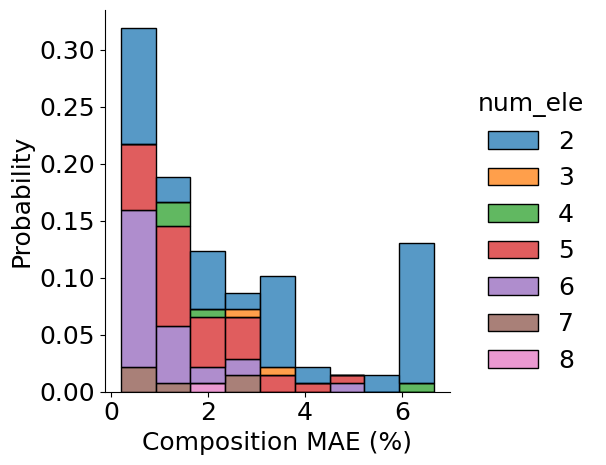

In [26]:
import seaborn as sns
# sns.color_palette("tab10")
ax = sns.displot(test_hea,  x="comp_diff_mae", hue="num_ele", stat="probability", 
            palette="tab10",  multiple="stack")
plt.xlabel('Composition MAE (%)')
# plt.savefig('figures/Test_composition_MAE.pdf')
# plt.savefig('figures/Test_composition_MAE.png')

Text(0.5, 21.444444444444457, 'Predicted target probability MAE (-)')

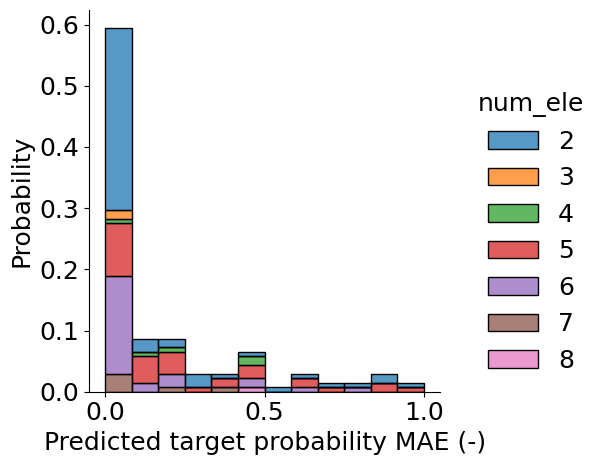

In [27]:
ax = sns.displot(test_hea,  x="y_diff", hue="num_ele", stat="probability", 
            palette="tab10",  multiple="stack")
plt.xlabel('Predicted target probability MAE (-)')
# plt.savefig('figures/Test_y_MAE.pdf')
# plt.savefig('figures/Test_y_MAE.png')

Text(0.5, 21.444444444444457, 'Latent space MAE (-)')

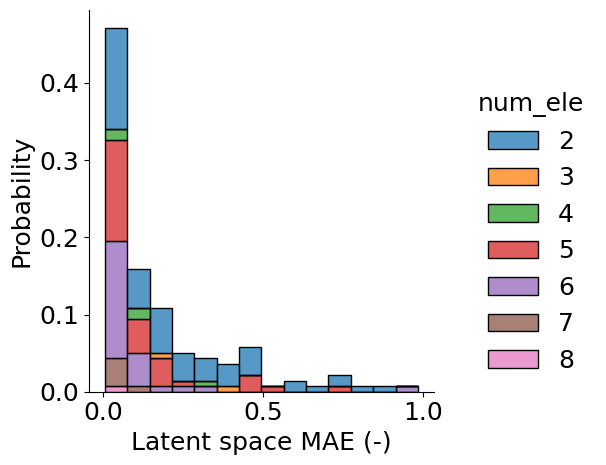

In [28]:
ax = sns.displot(test_hea,  x="z_diff_mae", hue="num_ele", stat="probability", 
            palette="tab10",  multiple="stack")
plt.xlabel('Latent space MAE (-)')
# plt.savefig('figures/Test_z_MAE.pdf')
# plt.savefig('figures/Test_z_MAE.png')

In [29]:
print(np.mean(test_hea.comp_diff_mae))
print(np.mean(test_hea.y_diff))
print(np.mean(test_hea.z_diff_mae))

2.331836926736791
0.16876811594202898
0.17451811


In [31]:
cols_to_save = ['Alloys'] + new_cols + cols_diff

test_hea.to_csv("data/test_data_reconstruction_analysis.csv", columns=cols_to_save, index=None)